# Lab 3: Stochastic Gradient Descent

### Students: Alassane DIALLO, Firas AZZOUZ

The goal of this lab session is to code an optimization algorithm that optimzes the penalized loss function of the logistic regression model.

You have to send the filled notebook named **"L3_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com by October 17, 2019. Please put **"AML-L3"** in the subject. 

We begin with the standard imports:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import random
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [ ]:
from sklearn import model_selection
from sklearn.metrics import accuracy_score

# data = pd.read_csv("w8a.csv", sep=";", header=None)
data = pd.read_csv("drive/My Drive/Colab Notebooks/w8a.csv", sep=";", header=None)
X = data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1].to_numpy()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size= 0.33, random_state=42)

## Logistic Regression



Today we’ll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', penalty="l2", C=2) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

and we compute the accuracy score to evaluate the model performance:

In [ ]:
print(f"Accuracy score on test data = {np.round(100 * accuracy_score(y_test, y_pred), 2)} %")

Accuracy score on test data = 98.53 %


### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization. 

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

##### Gradient of the loss function
$$ \nabla{F}(\theta) = \sum_{i=1}^n {-y_i\sigma(-y_i\theta^Tx_i)x_i} + \lambda\theta$$ where $\sigma$ is the sigmoid function.

In [ ]:
class StochasticLogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr_: float
        the learning rate
    bsize: integer
        the size of the mini-batch >=1
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
    """
    def __init__(self, strategy="vanilla", alpha=0, lr=1e-3, beta1=0.9, beta2=0.999, max_iter=100, batch_size=1, eps=1e-8, debias=True):
        assert strategy in ["vanilla", "adagrad", "adam"], 'strategy not implemented'
        self.strategy_ = strategy
        self.coef_  = None
        self.alpha_ = alpha
        self.lr_     = lr
        self.bsize_  = batch_size
        self.max_iter_ = max_iter
        self.coef_history_ = []
        self.f_history_ = []
        self.eps_ = eps
        self.beta1_ = beta1
        self.beta2_ = beta2
        self.debias_ = debias

    def logistic(self, z):
        # logistic function
          return 1/(1+np.exp(-z))

        
    def fit(self, X, y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """                    
        n, m = X.shape
        X_aug = np.ones((n, m +1))
        X_aug[:, 1:] = X

        #initialize: theta_init, grad_init, m_init, s_init
        theta_init = np.zeros(m+1)
        grad_init = np.zeros(m+1)
        self.coef_ = np.copy(theta_init)

        def compute_grad(theta, batch):     
            gradient_L = grad_init
            gradient_L+= self.alpha_* theta
            for i in batch:
              gradient_L+= -y[i] * self.logistic(-y[i] * np.dot(theta, X_aug[i])) * X_aug[i]         
            return gradient_L

        m_i = np.copy(grad_init)
        v_i = np.linalg.norm(grad_init)**2
        for iter in range(self.max_iter_):
            self.coef_history_.append(self.coef_)

            batch = np.random.randint(0, n , self.bsize_)
            g_i = compute_grad(self.coef_, batch)
            if self.strategy_ == "vanilla":
              v_i = 1
              m_i = g_i
            elif self.strategy_ == "adagrad":
              v_i+= np.linalg.norm(g_i)**2
              m_i = g_i
            
            elif self.strategy_ == "adam":
              m_i = (self.beta1_*m_i+(1-self.beta1_)*g_i)              
              v_i = self.beta2_*v_i+(1-self.beta2_)*(np.linalg.norm(g_i)**2)
              if self.debias_:
                m_i = m_i/(1-self.beta1_**(iter+1))
                v_i = v_i/(1-self.beta2_**(iter+1))

            self.coef_ = self.coef_ - (self.lr_/(np.sqrt(v_i) + self.eps_)) * m_i        
         
    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (0 or 1)
        """     
        n, m = X.shape
        X_aug = np.ones((n, m +1))
        X_aug[:, 1:] = X
        y_pred = np.zeros(n)
        for i in range(n):
            if self.coef_ @ X_aug[i] >= 0:
                y_pred[i] = 1
            else:
                y_pred[i] = -1
        return y_pred
                       

Apply to the data

In [ ]:
slr_vanilla = StochasticLogisticRegression(strategy="vanilla", lr=1e-3, alpha=0, max_iter=100, batch_size=1, eps=1e-8) 
slr_vanilla.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred_train = slr_vanilla.predict(X_train)
y_pred_test = slr_vanilla.predict(X_test)
print(f"Accuracy score on train data = {np.round(100 * accuracy_score(y_train, y_pred_train), 2)} %")
print(f"Accuracy score on test data = {np.round(100 * accuracy_score(y_test, y_pred_test), 2)} %")

Accuracy score on train data = 97.06 %
Accuracy score on test data = 96.97 %


In [ ]:
def loss_function(theta, X, y, alpha=0):
    n, m = X.shape     
    lf = 0.5 * alpha * np.linalg.norm(theta)**2
    for i in range(n):
        lf+= np.log(1+np.exp(-y[i] * np.dot(theta, X[i])))  
    return lf
          
def learning_curve(X, y, model):
    n, m = X.shape
    X_aug = np.ones((n, m +1))
    X_aug[:, 1:] = X
    loss_function_curve = [loss_function(theta, X_aug, y, model.alpha_) for theta in model.coef_history_]
    return loss_function_curve       

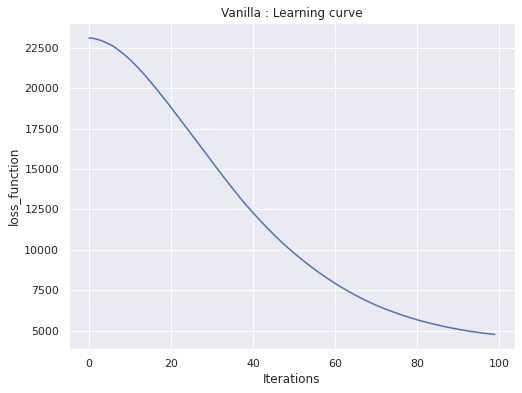

In [ ]:
loss_function_curve_vanilla = learning_curve(X_train, y_train, slr_vanilla)
fig = plt.figure(figsize=(8, 6))
plt.plot(loss_function_curve_vanilla)
plt.xlabel("Iterations")
plt.ylabel("loss_function")
plt.title("Vanilla : Learning curve")
plt.show()

With a vanilla implementation of the SGD, we obtain a minimum after 100 iterations, with a 1-element batch and no regularization. This results in a good accuracy on the test data (96.97 %). 
The algorithm is fast in time, but takes many iterations to converge.
<br> We will try to optimize the convergence time (number of iterations) by modifying different parameters (learning rate, batch size, regularization).

#### Parameters optimization
##### Learning rate


In [ ]:
lr_ = [1e-3,0.5e-3,1e-2,0.5e-1,1e-1]
model_dict = {}
model_loss = {}
model_time = {}
model_accuracy_test = {}
for elem in lr_ :
  start_time = time.time()
  model_dict[elem] = StochasticLogisticRegression(strategy = "vanilla", lr=elem)
  model_dict[elem].fit(X_train,y_train)
  model_time[elem] = time.time()-start_time
  model_loss[elem] = learning_curve(X_train, y_train, model_dict[elem])
  model_accuracy_test[elem] = np.round(100 * accuracy_score(y_test, model_dict[elem].predict(X_test)), 2)

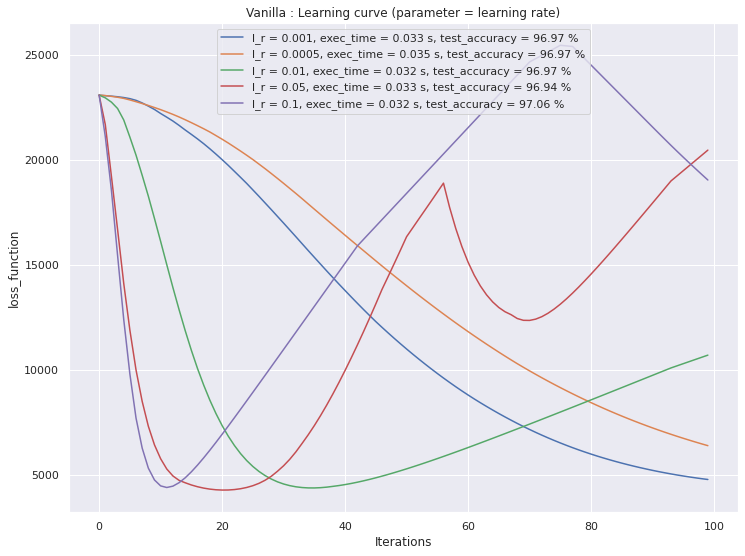

In [ ]:
fig = plt.figure(figsize=(12, 9))
for i,elem in enumerate(lr_):
    plt.plot(model_loss[elem], label=f"l_r = {elem}, exec_time = {np.round(model_time[elem],3)} s, test_accuracy = {model_accuracy_test[elem]} %")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("loss_function")
plt.title("Vanilla : Learning curve (parameter = learning rate)")
plt.show()

After increasing the learning rate to a certain value, the vanilla SGD gives a local minimum in less iterations, but diverges rapidily after. So raising the value of the learning rate too much can lead the algorithm to diverge, especially that we are using a 1-element batch which increases the noise of the gradient signal.

##### Batch size

In [ ]:
batch_size = [1,50,100,200,300]
model_dict = {}
model_loss = {}
model_time = {}
model_accuracy_test = {}
for elem in batch_size :
  start_time = time.time()
  model_dict[elem] = StochasticLogisticRegression(strategy = "vanilla", batch_size=elem)
  model_dict[elem].fit(X_train,y_train)
  model_time[elem] = time.time()-start_time
  model_loss[elem] = learning_curve(X_train, y_train, model_dict[elem])
  model_accuracy_test[elem] = np.round(100 * accuracy_score(y_test, model_dict[elem].predict(X_test)), 2)

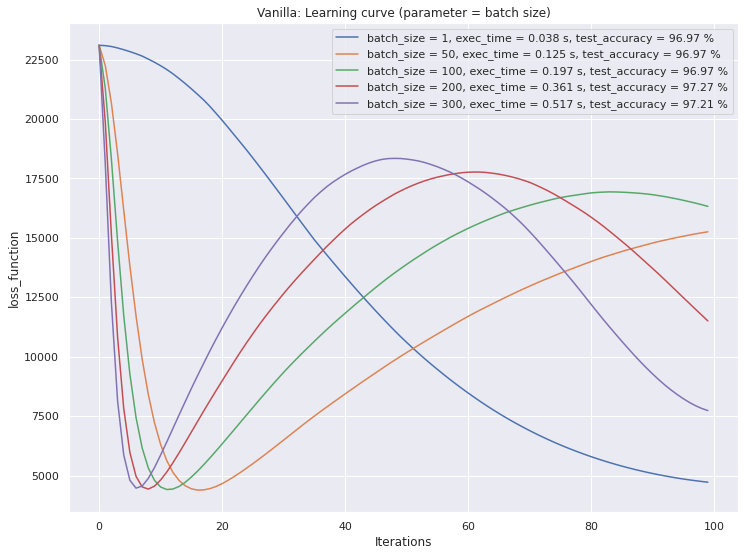

In [ ]:
fig = plt.figure(figsize=(12, 9))
for i,elem in enumerate(batch_size):
    plt.plot(model_loss[elem], label=f"batch_size = {elem}, exec_time = {np.round(model_time[elem],3)} s, test_accuracy = {model_accuracy_test[elem]} %")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("loss_function")
plt.title("Vanilla: Learning curve (parameter = batch size)")
plt.show()

The SGD algorithms gives a local minima in less iterations if we increase the size of the batch, but the execution time goes upwards. This is understandable, because at each iteration, we take into account more elements, so we have a more stable algorithm with a smoother convergence.

##### Regularization



In [ ]:
alpha_ = [0,0.1,1,5,10,100]
model_dict = {}
model_loss = {}
model_time = {}
model_accuracy_test = {}
for elem in alpha_ :
  start_time = time.time()
  model_dict[elem] = StochasticLogisticRegression(strategy = "vanilla", alpha=elem)
  model_dict[elem].fit(X_train,y_train)
  model_time[elem] = time.time()-start_time
  model_loss[elem] = learning_curve(X_train, y_train, model_dict[elem])
  model_accuracy_test[elem] = np.round(100 * accuracy_score(y_test, model_dict[elem].predict(X_test)), 2)

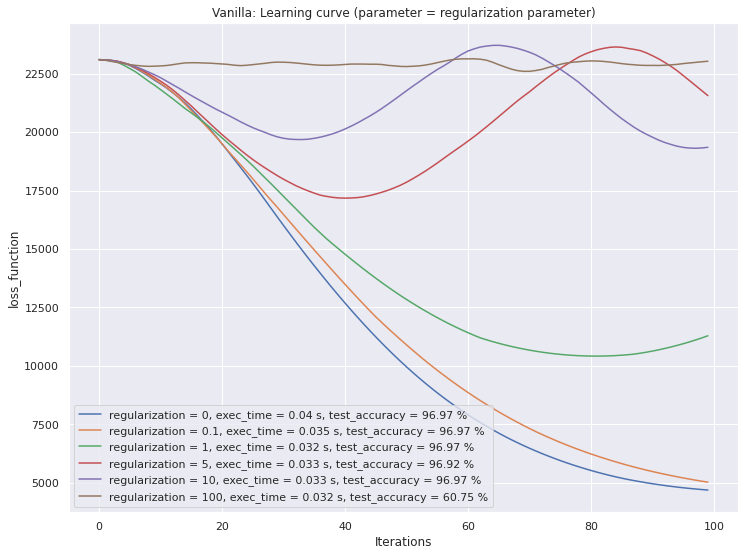

In [ ]:
fig = plt.figure(figsize=(12, 9))
for i,elem in enumerate(alpha_):
    plt.plot(model_loss[elem], label=f"regularization = {elem}, exec_time = {np.round(model_time[elem],3)} s, test_accuracy = {model_accuracy_test[elem]} %")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("loss_function")
plt.title("Vanilla: Learning curve (parameter = regularization parameter)")
plt.show()

When we change the value of the regularization parameter, we change the loss function, so it's understandable that the minimum increases with this parameter. We see that a value of 1 gives a better convergence (over less iterations), but does not change the accuracy on the test data.

## Acceleration Strategies

In this section, we will study two acceleration strategies for gradient descent: Adagrad and ADAM. For each strategies, we will see the effect of parameters like learning rate, batch size and regularization on the convergence. In case of the ADAM SGD, two more parameters will be also tuned: $\beta_1$ and $\beta_2$.

#### Adagrad

In [ ]:
slr_adagrad = StochasticLogisticRegression(strategy="adagrad", lr=1e-1, alpha=0, max_iter=100, batch_size=1, eps=1e-8) 
slr_adagrad.fit(X_train, y_train)

In [ ]:
y_pred_train = slr_adagrad.predict(X_train)
y_pred_test = slr_adagrad.predict(X_test)
print(f"Accuracy score on train data = {np.round(100 * accuracy_score(y_train, y_pred_train), 2)} %")
print(f"Accuracy score on test data = {np.round(100 * accuracy_score(y_test, y_pred_test), 2)} %")

Accuracy score on train data = 97.06 %
Accuracy score on test data = 96.97 %


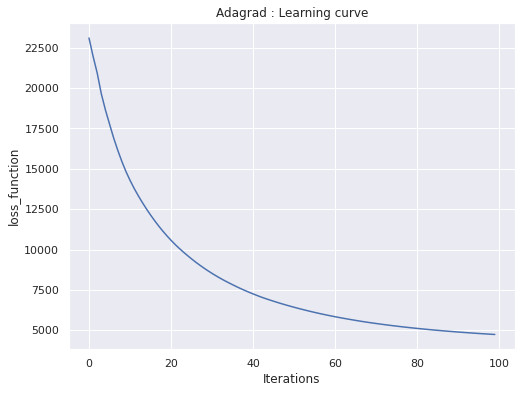

In [ ]:
loss_function_curve_adagrad = learning_curve(X_train, y_train, slr_adagrad)
fig = plt.figure(figsize=(8, 6))
plt.plot(loss_function_curve_adagrad)
plt.xlabel("Iterations")
plt.ylabel("loss_function")
plt.title("Adagrad : Learning curve")
plt.show()

#### Parameters optimization
##### Learning rate


In [ ]:
lr_ = [1e-2, 1e-1, 5e-1, 1e0]
model_dict = {}
model_loss = {}
model_time = {}
model_accuracy_test = {}
for elem in lr_ :
  start_time = time.time()
  model_dict[elem] = StochasticLogisticRegression(strategy = "adagrad", lr=elem)
  model_dict[elem].fit(X_train,y_train)
  model_time[elem] = time.time()-start_time
  model_loss[elem] = learning_curve(X_train, y_train, model_dict[elem])
  model_accuracy_test[elem] = np.round(100 * accuracy_score(y_train, y_pred_train), 2)

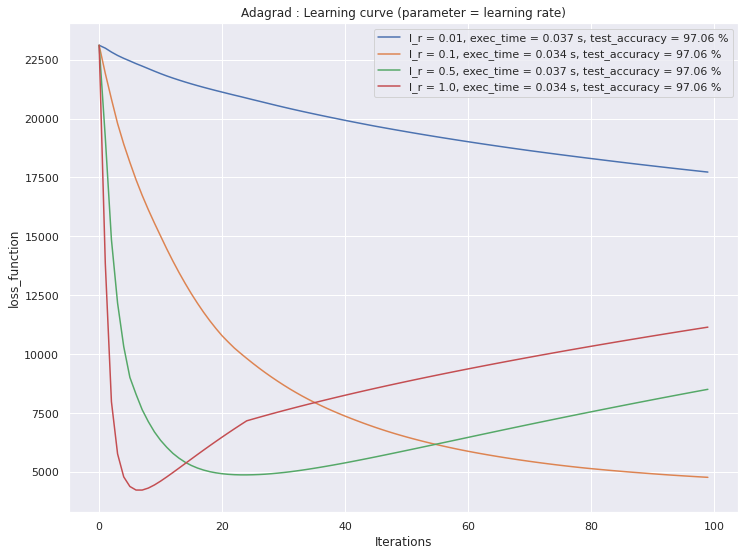

In [ ]:
fig = plt.figure(figsize=(12, 9))
for i,elem in enumerate(lr_):
    plt.plot(model_loss[elem], label=f"l_r = {elem}, exec_time = {np.round(model_time[elem],3)} s, test_accuracy = {model_accuracy_test[elem]} %")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("loss_function")
plt.title("Adagrad : Learning curve (parameter = learning rate)")
plt.show()

In adagrad algorithm, the learning rate is not constant. It decreases when the norm of the gradient increases. So the value specified in the graph above is used to give the initial learning rate. We see that the best (initial) learning rate to obtain a minimum in 100 iterations is 0.1, but the best value to get the fastest convergence to a minimum is 0.5. Above these values, the algorithm diverges but less erratically than vanilla SGD.

##### Batch size

In [ ]:
batch_size = [1,50,100,200,300]
model_dict = {}
model_loss = {}
model_time = {}
model_accuracy_test = {}
for elem in batch_size :
  start_time = time.time()
  model_dict[elem] = StochasticLogisticRegression(strategy = "adagrad", batch_size=elem, lr=1e-1)
  model_dict[elem].fit(X_train,y_train)
  model_time[elem] = time.time()-start_time
  model_loss[elem] = learning_curve(X_train, y_train, model_dict[elem])
  model_accuracy_test[elem] = np.round(100 * accuracy_score(y_test, model_dict[elem].predict(X_test)), 2)

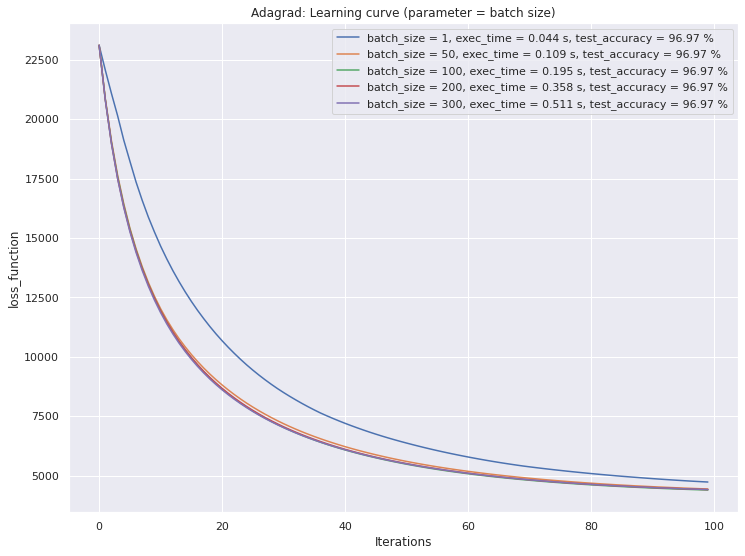

In [ ]:
fig = plt.figure(figsize=(12, 9))
for i,elem in enumerate(batch_size):
    plt.plot(model_loss[elem], label=f"batch_size = {elem}, exec_time = {np.round(model_time[elem],3)} s, test_accuracy = {model_accuracy_test[elem]} %")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("loss_function")
plt.title("Adagrad: Learning curve (parameter = batch size)")
plt.show()

By trying the minibatch variant of gradiant descent on adagrad algorithm, we see that it does not change drastically the speed at which we attain a minimum, in comparison to vanilla algorithm, where the convergence is a lot faster and smoother when we increase the size of the batch. We see here that a batch of 50 is enough to get the best results.

##### Regularization

In [ ]:
alpha_ = [0,0.1,1,5,10,100]
model_dict = {}
model_loss = {}
model_time = {}
model_accuracy_test = {}
for elem in alpha_ :
  start_time = time.time()
  model_dict[elem] = StochasticLogisticRegression(strategy = "adagrad", alpha=elem, lr=1e-1)
  model_dict[elem].fit(X_train,y_train)
  model_time[elem] = time.time()-start_time
  model_loss[elem] = learning_curve(X_train, y_train, model_dict[elem])
  model_accuracy_test[elem] = np.round(100 * accuracy_score(y_test, model_dict[elem].predict(X_test)), 2)

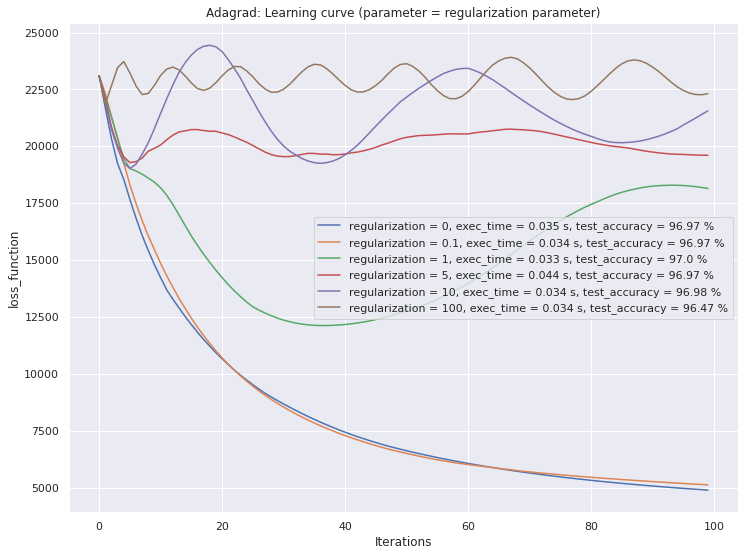

In [ ]:
fig = plt.figure(figsize=(12, 9))
for i,elem in enumerate(alpha_):
    plt.plot(model_loss[elem], label=f"regularization = {elem}, exec_time = {np.round(model_time[elem],3)} s, test_accuracy = {model_accuracy_test[elem]} %")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("loss_function")
plt.title("Adagrad: Learning curve (parameter = regularization parameter)")
plt.show()

When we set the regularization parameter to 1, we get the fastest convergence to a minimum, but the algorithm diverges after. The accuracy on the test data is also slightly higher at this value.

#### ADAM

In [ ]:
slr_adam = StochasticLogisticRegression(strategy="adam", lr=1e-3, alpha=0, max_iter=100, batch_size=1, eps=1e-8, beta1=0.9, beta2=0.8) 
slr_adam.fit(X_train, y_train)

In [ ]:
y_pred_train = slr_adam.predict(X_train)
y_pred_test = slr_adam.predict(X_test)
print(f"Accuracy score on train data = {np.round(100 * accuracy_score(y_train, y_pred_train), 2)} %")
print(f"Accuracy score on test data = {np.round(100 * accuracy_score(y_test, y_pred_test), 2)} %")

Accuracy score on train data = 97.06 %
Accuracy score on test data = 96.97 %


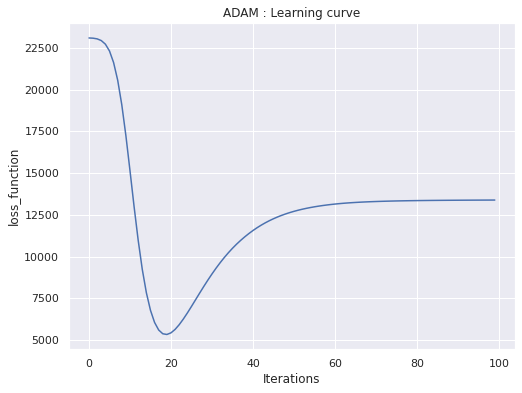

In [ ]:
loss_function_curve_adam = learning_curve(X_train, y_train, slr_adam)
fig = plt.figure(figsize=(8, 6))
plt.plot(loss_function_curve_adam)
plt.xlabel("Iterations")
plt.ylabel("loss_function")
plt.title("ADAM : Learning curve")
plt.show()

On the above graph, we see that SGD with ADAM gives a fast convergence to a minimum in less than 20 iterations.

### Hyperparameter optimisation ADAM

### Learning rate 

In [ ]:
lr_ =  [1e-4, 5e-4, 1e-3, 5e-3]
model_dict = {}
model_loss = {}
model_time = {}
model_accuracy_test = {}
for elem in lr_ :
  start_time = time.time()
  model_dict[elem] = StochasticLogisticRegression(strategy = "adam", lr=elem, beta1=0.9, beta2=0.8)
  model_dict[elem].fit(X_train,y_train)
  model_time[elem] = time.time()-start_time
  model_loss[elem] = learning_curve(X_train, y_train, model_dict[elem])
  model_accuracy_test[elem] = np.round(100 * accuracy_score(y_test, model_dict[elem].predict(X_test)), 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


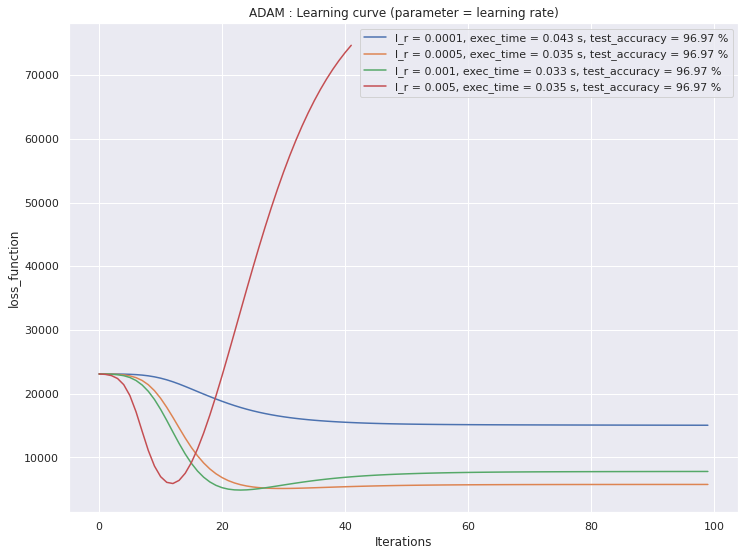

In [ ]:
fig = plt.figure(figsize=(12, 9))
for i,elem in enumerate(lr_):
    plt.plot(model_loss[elem], label=f"l_r = {elem}, exec_time = {np.round(model_time[elem],3)} s, test_accuracy = {model_accuracy_test[elem]} %")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("loss_function")
plt.title("ADAM : Learning curve (parameter = learning rate)")
plt.show()


The (initial) learning rate value for the adam algorithm controls both the speed of the convergence and the minimum value reached by the loss function. For a small learning rate we do not reach the minimum value in 100 iterations. For a high small rate, we have a fast convergence but the algorithm diverges rapidily after. The best value is 5e-4 (orange line) because it gives a minimum at 30 iterations and then the loss function does not diverge.

#### Batch_size


In [ ]:
batch_size = [1,50,100,200,300]
model_dict = {}
model_loss = {}
model_time = {}
model_accuracy_test = {}
for elem in batch_size :
  start_time = time.time()
  model_dict[elem] = StochasticLogisticRegression(strategy = "adam", batch_size=elem, beta1=0.9, beta2=0.8)
  model_dict[elem].fit(X_train,y_train)
  model_time[elem] = time.time()-start_time
  model_loss[elem] = learning_curve(X_train, y_train, model_dict[elem])
  model_accuracy_test[elem] = np.round(100 * accuracy_score(y_test, model_dict[elem].predict(X_test)), 2)

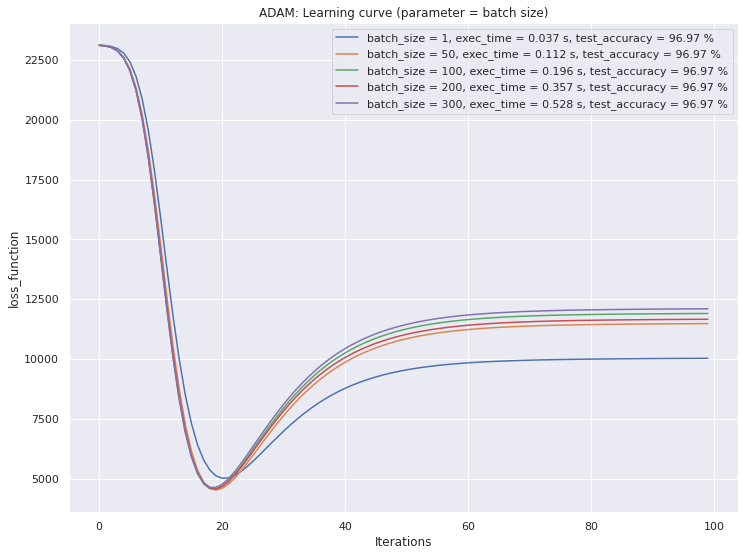

In [ ]:
fig = plt.figure(figsize=(12, 9))
for i,elem in enumerate(batch_size):
    plt.plot(model_loss[elem], label=f"batch_size = {elem}, exec_time = {np.round(model_time[elem],3)} s, test_accuracy = {model_accuracy_test[elem]} %")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("loss_function")
plt.title("ADAM: Learning curve (parameter = batch size)")
plt.show()

The batch size does not have too much effect on the convergence speed. A 50-element is enough to get the best convergence. We can explain it by the fact that we take into account various values of gradients (of the past) in each iteration, so we get a smooth convergence where the update value of the gradient already depends on many observations even for a batch of size 1.

#### hyperparameter beta1 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


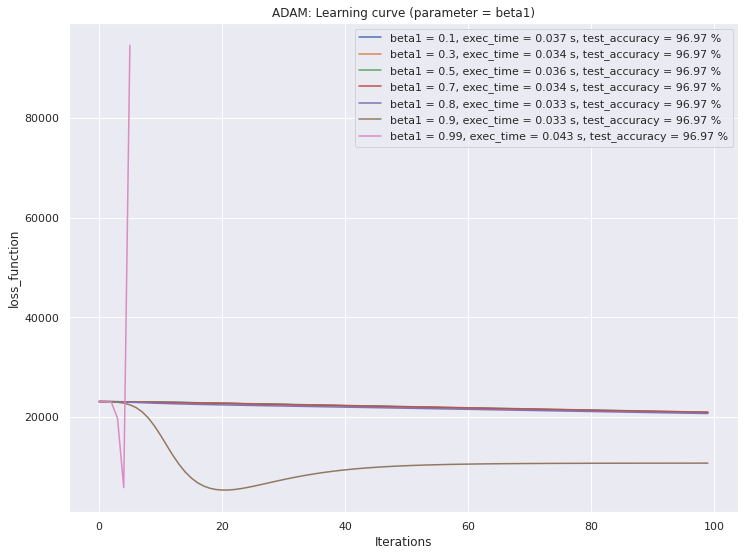

In [ ]:
beta1 = [0.1,0.3,0.5,0.7,0.8,0.9,0.99]
model_dict = {}
model_loss = {}
model_time = {}
model_accuracy_test = {}
for elem in beta1 :
  start_time = time.time()
  model_dict[elem] = StochasticLogisticRegression(strategy = "adam", beta1=elem, beta2=0.8)
  model_dict[elem].fit(X_train,y_train)
  model_time[elem] = time.time()-start_time
  model_loss[elem] = learning_curve(X_train, y_train, model_dict[elem])
  model_accuracy_test[elem] = np.round(100 * accuracy_score(y_test, model_dict[elem].predict(X_test)), 2)
  
fig = plt.figure(figsize=(12, 9))
for i,elem in enumerate(beta1):
    plt.plot(model_loss[elem], label=f"beta1 = {elem}, exec_time = {np.round(model_time[elem],3)} s, test_accuracy = {model_accuracy_test[elem]} %")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("loss_function")
plt.title("ADAM: Learning curve (parameter = beta1)")
plt.show()


The convergence is very sensitive to the parameter $\beta_1$ :
<li> For a low value of $\beta_1$, we get a behaviour similar to adagrad. The slow convergence is due to the setting of $\beta_2$ which is not optimal for low values of $\beta_1$.
<li> For high values of $\beta_1$, the update value depend less on the current gradient and much more on the pase values. The algorithm is unstable for $\beta_1 = 0.9$ here bacause of the debiasing term.
<li> The optimal value is $\beta_2 = 0.8$.

### Hyperparameter beta2

In [ ]:
beta2 = [0.1,0.3,0.5,0.7,0.8,0.9,0.99]
model_dict = {}
model_loss = {}
model_time = {}
model_accuracy_test = {}
for elem in beta2 :
  start_time = time.time()
  model_dict[elem] = StochasticLogisticRegression(strategy = "adam", beta1=0.9, beta2=elem)
  model_dict[elem].fit(X_train,y_train)
  model_time[elem] = time.time()-start_time
  model_loss[elem] = learning_curve(X_train, y_train, model_dict[elem])
  model_accuracy_test[elem] = np.round(100 * accuracy_score(y_test, model_dict[elem].predict(X_test)), 2)

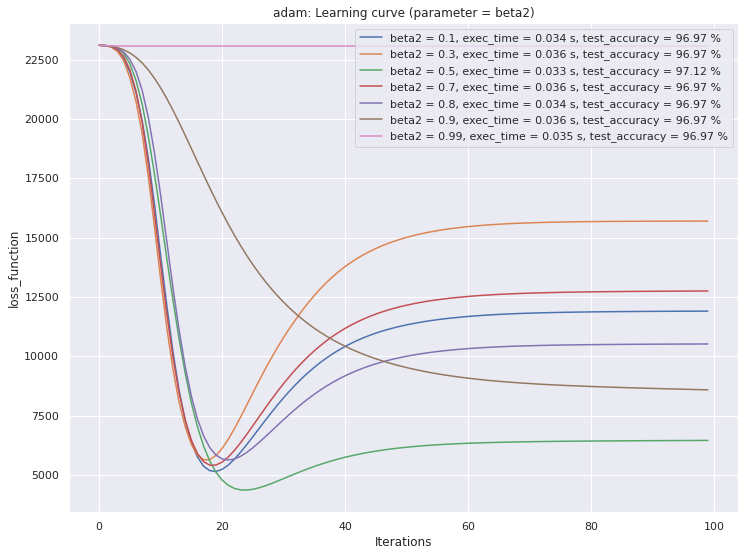

In [ ]:
fig = plt.figure(figsize=(12, 9))
for i,elem in enumerate(beta2):
    plt.plot(model_loss[elem], label=f"beta2 = {elem}, exec_time = {np.round(model_time[elem],3)} s, test_accuracy = {model_accuracy_test[elem]} %")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("loss_function")
plt.title("adam: Learning curve (parameter = beta2)")
plt.show()

<li> For high values of $\beta_2$, the speed is more dependent on the past than on the current gradient. Because of the debiasing term, we get here a low value for the update term, so a slow convergence.
<li> Lower values give better results
<li> Equal contribution of the past and the current gradien $\beta_2 = 0.5$ (green line) gives the best results with the highest accuracy on test data (97.12%)

#### Regularization parameter


In [ ]:
alpha_ = [0,0.1,1,5,10,100]
model_dict = {}
model_loss = {}
model_time = {}
model_accuracy_test = {}
for elem in alpha_ :
  start_time = time.time()
  model_dict[elem] = StochasticLogisticRegression(strategy = "adam", alpha=elem, beta1=0.9, beta2=0.8)
  model_dict[elem].fit(X_train,y_train)
  model_time[elem] = time.time()-start_time
  model_loss[elem] = learning_curve(X_train, y_train, model_dict[elem])
  model_accuracy_test[elem] = np.round(100 * accuracy_score(y_test, model_dict[elem].predict(X_test)), 2)

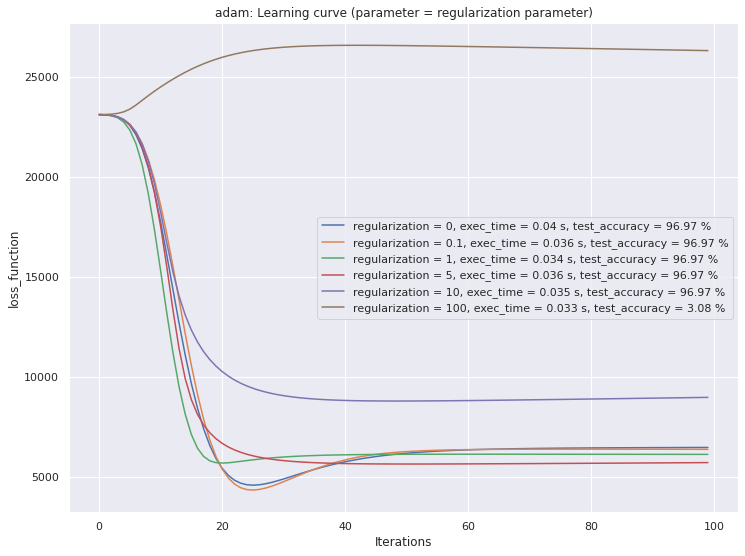

In [ ]:
fig = plt.figure(figsize=(12, 9))
for i,elem in enumerate(alpha_):
    plt.plot(model_loss[elem], label=f"regularization = {elem}, exec_time = {np.round(model_time[elem],3)} s, test_accuracy = {model_accuracy_test[elem]} %")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("loss_function")
plt.title("adam: Learning curve (parameter = regularization parameter)")
plt.show()

Regularization parameter gives for the ADAM algorithm a stable minimum for the values among 1, 5 and 10.

#Comparison between Vanilla, Adagrad and ADAM algorithms

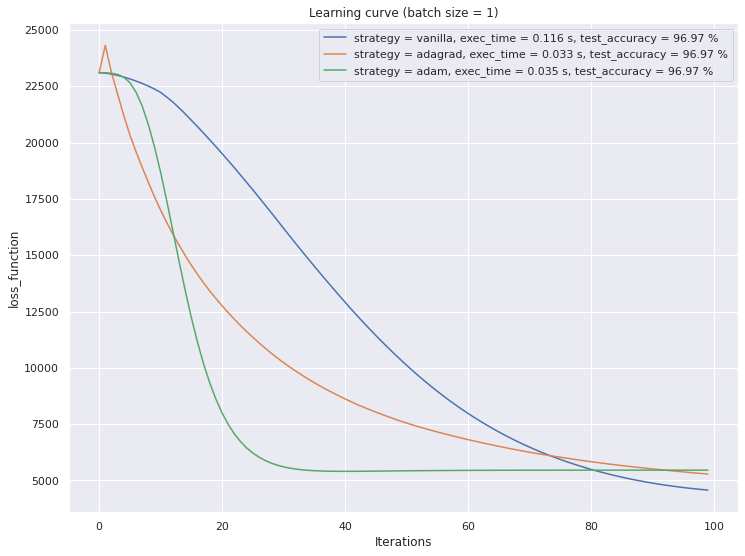

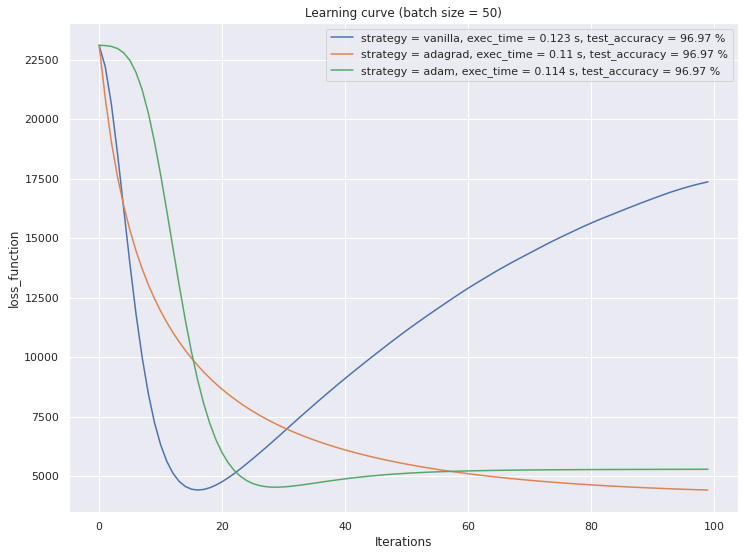

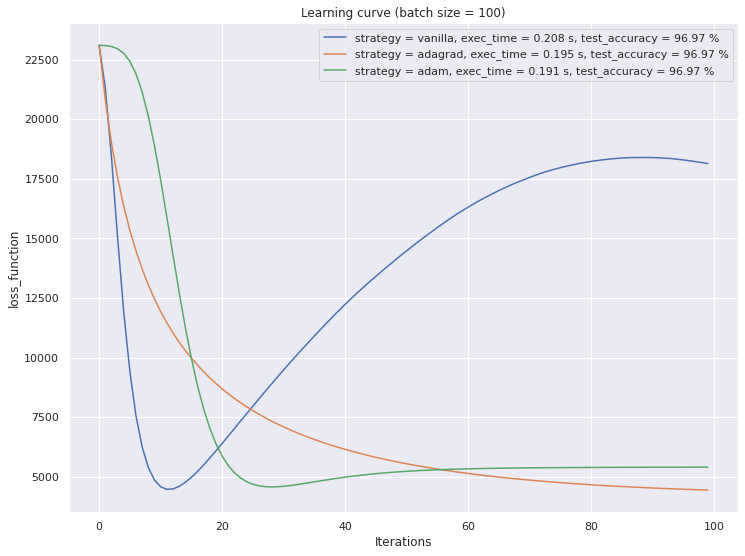

In [15]:
strategies = ["vanilla", "adagrad", "adam"]
learning_rate = {"vanilla" : 1e-3, "adagrad" : 1e-1, "adam" : 5e-4}
batch_size = [1,50,100]
# batch_size = [1]
for b_size in batch_size:
  model_dict = {}
  model_loss = {}
  model_time = {}
  model_accuracy_test = {}
  for elem in strategies :
    start_time = time.time()
    model_dict[elem] = StochasticLogisticRegression(strategy = elem, lr=learning_rate[elem], batch_size=b_size, beta1=0.9, beta2=0.5)
    model_dict[elem].fit(X_train,y_train)
    model_time[elem] = time.time()-start_time
    model_loss[elem] = learning_curve(X_train, y_train, model_dict[elem])
    model_accuracy_test[elem] = np.round(100 * accuracy_score(y_test, model_dict[elem].predict(X_test)), 2)

  fig = plt.figure(figsize=(12, 9))
  for elem in strategies:
      plt.plot(model_loss[elem], label=f"strategy = {elem}, exec_time = {np.round(model_time[elem],3)} s, test_accuracy = {model_accuracy_test[elem]} %")
  plt.legend()
  plt.xlabel("Iterations")
  plt.ylabel("loss_function")
  plt.title(f"Learning curve (batch size = {b_size})")
  plt.show()

### Comments on the observations:

In order to understand the effect of hyperparameters on the different algorithms(ADAM, Adagrad, Vanilla), we tried to change their values and to see the effect on different aspects of the algorithm:
<li> Convergence under a number of iterations (100): whether we reach or not a minimum.
<li> Convergence speed: the number of iterations needed to reach the minimum.
<li> Execution time: total execution time (without counting the time needed to compute the loss function which is not needed in the minimization process but only to show the learning curve).
<li> Accuracy on test data.
<li> Divergence: whether the minimum is stable or not.

As we can see from the above graphs there is no unique optimal algorithm that outperforms others in all scenarios. Some outperform with the increase of the batch size(like vanilla) while others give better performance with other hyperparameters. 

That being said some logical reasoning can be stated from some of the results: <li> The increase of the speed of convergence with the batch size which can be explained by the fact that more data have more resilience to noises.
<li> The divergence of Vanilla after we reach the minimum, but the stability of Adagrad and ADAM after the minimum.
<li> The increase of execution time with the size of the batch.

We can also deduce that ADAM and Adagrad are better to get the fastest convergence with low batch size, so with less execution time. The convergence is also more stable for these two algorithms, compared to vanilla algorithm.

Another point we've noticed is the sensitivity of the algorithms to their hyperparameters. In the case of adam, it is critically important to choose right hyperparameters ($\beta1$ and $\beta2$) to avoid converging to a local minimum . This clearly depicts the importance of hyperparameter tuning for gradient descent.  
